In [1]:
import numpy as np
import matplotlib.pyplot as plt
from moirae.models.ecm import EquivalentCircuitModel as ECM
from moirae.models.ecm import ECMASOH, ECMInput, ECMTransientVector
from moirae.simulator import Simulator

Let's define some specifications for the different models we will consider.

In [2]:
specifications = {'rint': {'has_C0': False, 'num_RC': 0},
                  'thenevin': {'has_C0': False, 'num_RC': 1},
                  'pngv': {'has_C0': True, 'num_RC': 2}}

Now, we can collect the default templates of A-SOH for each of these.

In [3]:
asoh_dict = {}
for model_name, specs in specifications.items():
    asoh_dict[model_name] = ECMASOH.provide_template(has_C0=specs['has_C0'], num_RC=specs['num_RC'])

Since every default template uses the same OCV, we can just choose one and plot it.

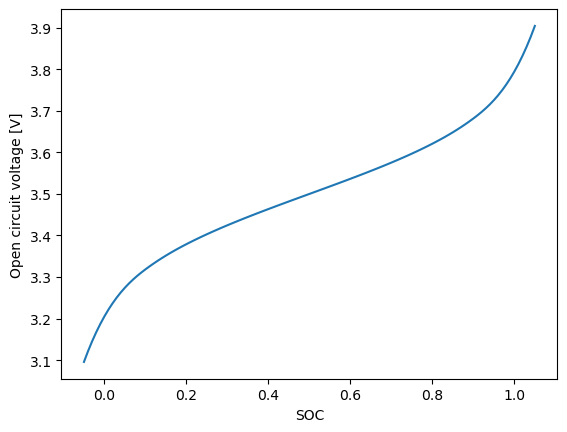

In [4]:
soc_vals = np.linspace(-0.05, 1.05, 111)
ocv = asoh_dict['rint'].ocv(soc=soc_vals).squeeze()

plt.plot(soc_vals, ocv)
plt.ylabel('Open circuit voltage [V]')
_ = plt.xlabel('SOC')

Let us initialize the different simulators.

In [5]:
simulators = {}
for model_name, asoh in asoh_dict.items():
    simulators[model_name] = Simulator(cell_model=ECM(),
                                       asoh=asoh,
                                       initial_input=ECMInput(),
                                       transient_state=ECMTransientVector.from_asoh(asoh),
                                       keep_history=True)

Here, the battery starts discharged, and has a maximum capacity of 10 Amp-hours.


We will simulate the following processes, in order:
1. charge: duration of 25 minutes; current of 5 A
2. rest: duration of 5 minutes
3. discharge: duration of 15 minutes; current of 7 A
4. rest: duration of 2 minutes

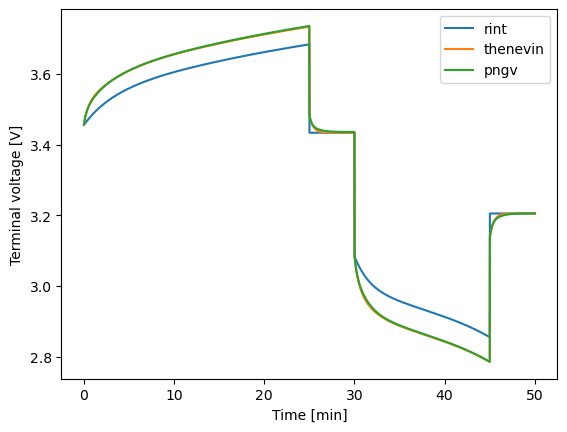

In [6]:
charge_time = 60 * 25
rest_time = 60 * 5
discharge_time = 60 * 15
timestamps = np.arange(charge_time + rest_time + discharge_time + rest_time) + 1
timestamps = timestamps.tolist()
currents = [5] * charge_time
currents += [0] * rest_time
currents += [-7] * discharge_time
currents += [0] * rest_time
# Prepare list of inputs
ecm_inputs = [ECMInput(time=time, current=current) \
              for (time, current) in zip(timestamps, currents)]

# Dictionary to store results
voltages = {}
for model_name, simulator in simulators.items():
    measurements = simulator.evolve(ecm_inputs)
    voltages[model_name] = [measure.terminal_voltage.item() for measure in measurements]

# Convert time back to minutes for plotting
timestamps = np.array(timestamps) / 60
# Plot
fig, ax = plt.subplots()
for model_name, volts in voltages.items():
    ax.plot(timestamps, volts, label=model_name)
ax.set_xlabel('Time [min]')
ax.set_ylabel('Terminal voltage [V]')
ax.legend()

Finally, let's just make sure things are working in order, and all simulators share the same SOC values. 

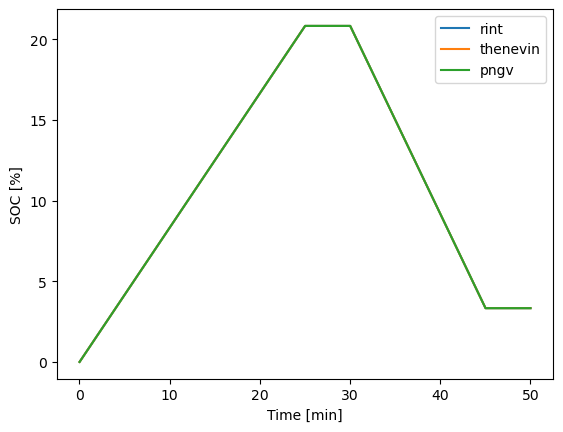

In [7]:
SOCs = {}
for model_name, simulator in simulators.items():
    soc_vals = [transient.soc.item() for transient in simulator.transient_history]
    SOCs[model_name] = soc_vals

# Plotting
fig, ax = plt.subplots()
for model_name, soc_vals in SOCs.items():
    ax.plot(timestamps, 100 * np.array(soc_vals[1:]), label=model_name)
ax.set_xlabel('Time [min]')
ax.set_ylabel('SOC [%]')
ax.legend()